In [1]:
import xarray as xr
import numpy as np
import math
import datetime
import yaml

import matplotlib.pyplot as plt
import cmocean as cm  

In [2]:
#This file contains configuration details like API keys and passwords
global_vars = yaml.safe_load(open('../config.yml', 'r') )

In [3]:
#This has custom functions - namely finding timeframes and graphing
%run ./00_custom_functions.ipynb   

In [4]:
#set data folders for input and output
input_folder = global_vars['reconstruction_folder']
reconstructed_file = input_folder + 'pCO2_LEAP_XGBoost-fco2-residual-reconstructed_198201-202212.nc'
seaflux_file = global_vars['download_folder'] + 'SeaFlux/originals/SeaFlux_LDEO_SeaFlux-v202301-all_1982-2022.nc'
    #previously:     #seaflux_file = '/data/artemis/observations/SeaFlux/SeaFlux_v2022.01_no_pco2.nc'
coastal_filling_file = global_vars['download_folder']+'pCO2/processed/fCO2_NOAA-NCEI_MPI-ULB-SOM-FFN_198201-202304.nc'
    #previously:     #coastal_filling_file = '/data/artemis/observations/SeaFlux/Coastal_fill_scaling_LDEOtmp.nc'  
output_folder = input_folder   #Because we are inputting and outputting processed files, the folder can be the same

flux_variable = 'fco2'  #for differentiating between pco2 flux and fco2 flux. Used for naming as well

#This variable sets the output file type. 
#When using cloud storage, it is recommended to use ARCO (Analysis-Ready Cloud-Optimized) formats like Zarr over NetCDF
output_file_type = '.zarr' if input_folder[0:5] == 'gs://' else '.nc'
print(f'Files will be outputed as: {output_file_type}')

Files will be outputed as: .nc


#### Ensure Common Gridding

In [5]:
recon_ens = xr_open_dataset_custom(reconstructed_file)
seaflux = xr_open_dataset_custom(seaflux_file)
coast_unscaled = xr_open_dataset_custom(coastal_filling_file)

In [6]:
# To match the reconstructed data, we need each file to be in this format: time, ylat, xlon 
    # with time ranges on the 15th of the month, 
    # and ylat and xlon on 1 degree resolution (ylat from -89.5 to 89.5; xlon from -179.5 to 179.5)
# This code checks these conditions
#If anything errors out, we would need to reformat the input data prior to this script

if True: #these are known changes required from the 2021 version but may not be needed in other versions
    seaflux = seaflux.rename({'lat': 'ylat', 'lon':'xlon'})
    seaflux = seaflux.transpose('time','ylat','xlon',...)

#check coordinate naming
assert set(list(seaflux.coords)) >= {'time','ylat','xlon'}
assert set(list(coast_unscaled.coords)) >= {'time','ylat','xlon'}

#check mid-month date
assert set(list([x.astype('datetime64[s]').item().day for x in seaflux.time.data])) == {15}
assert set(list([x.astype('datetime64[s]').item().day for x in coast_unscaled.time.data])) == {15}

#check grid resolution
assert set(list(seaflux.ylat.values)) <= set([x+.5 for x in range(-90, 90, 1)])
assert set(list(seaflux.xlon.values)) <= set([x+.5 for x in range(-180,180,1)])
assert set(list(coast_unscaled.ylat.values)) <= set([x+.5 for x in range(-90, 90, 1)])
assert set(list(coast_unscaled.xlon.values)) <= set([x+.5 for x in range(-180,180,1)])

#### Find Common Timeframe

In [7]:
start_yearmonth, end_yearmonth = find_least_date_range([recon_ens, seaflux, coast_unscaled]) #ocean area does not have a time component so is not included

print(f'Annual flux calculations will output from: {start_yearmonth} to {end_yearmonth}')

Annual flux calculations will output from: 1982-01 to 2022-12


#### Convert Coastal Filling

In [8]:
weights = np.cos(np.deg2rad(recon_ens.ylat)) #global area weighted version
weights.name = "weights"
scaling_weighted = (recon_ens.fco2_reconstructed/coast_unscaled.fco2).weighted(weights).mean(['xlon','ylat']) 
#scaling_weighted.plot()
coast_scaled = coast_unscaled.fco2*scaling_weighted

In [9]:
coast_new = xr.Dataset( {
                        'coastal_clim_scaled':(["time","ylat","xlon"],coast_scaled.data)
                        },
                        coords={'time': (['time'],coast_scaled.time.data), 
                          'ylat': (['ylat'],coast_scaled.ylat.data),
                          'xlon': (['xlon'],coast_scaled.xlon.data)}
                      )
coast_new.coastal_clim_scaled.attrs['description'] = 'Landschutzer coastal full climatology, expanded to all years, in fco2 using a scaling factor from CO2 Residual'
coast_new.coastal_clim_scaled.attrs['units'] = 'uatm'
coast_new.attrs['title']="Coastal Clim fCO2 from residual"
coast_new.attrs['notes']="see methods in SeaFlux ESSD paper to learn how to do this"
coast_new.attrs['notes2']="converted the original pCO2 to fCO2 for use in GCB method"
coast_new.attrs['history']="Run by ds4114"
coast_new.attrs['institution']="Lamont Doherty Earth Observatory at Columbia"
coast_new.attrs['references']="/home/ds4114/repos/LDEO_Ocean_CO2_Residual/05_calculate_flux.ipynb"
coast_new.attrs['date_created']=str(datetime.datetime.now())
#coast_new

## Calculate Flux

In [17]:
#filter to same time frame
seaflux_filter = seaflux.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
coast_filter = coast_new.coastal_clim_scaled.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
recon_ens_filter = recon_ens.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 

In [18]:
%%time
wind_prods = ["CCMP2","ERA5","JRA55"]
kw1 = seaflux_filter.kw.sel(wind=wind_prods) #just get the 3 winds we want. 
kw = kw1 * 87.6        # --> cm/hr now m/yr
kw = kw.where(kw > 0)  # solubility (mol/m3/uatm) and kw converted from (cm/hr) to (m/s)
if seaflux_filter.sol.mean() > 0.01 :   #adding a threshold in case the uploaded data is in a different unit
    k0 = seaflux_filter.sol/1000        # mol / m3 / uatm. Note that in this new version of Seaflux the data is in a different unit
                                        # May be updated in future version
else:
    k0 = seaflux_filter.sol
icef = seaflux_filter.ice     # ice fraction 
ice_weighting = 1 - icef.fillna(0)

CPU times: user 35.9 s, sys: 19.5 s, total: 55.3 s
Wall time: 55.7 s


In [19]:
#Now process reconstructed ocean_co2 and create pco2 delta
ocean_co2 = recon_ens_filter[flux_variable+'_reconstructed'] #ex. recon_ens_filter.pco2_reconstructed
ocean_co2_filled = ocean_co2.fillna(coast_filter)  
delta_co2 = ocean_co2_filled - seaflux_filter.fco2atm   #Note we will subtract the same atmosphereic fco2 for either flux_variable

In [20]:
#calculate flux
flux = ( k0 * kw * delta_co2 * ice_weighting ) # mol/m2/yr
flux = flux.chunk(-1) #this is to avoid errors if exporting as .zarr
flux_xr = xr.Dataset({'flux':(["time","ylat","xlon","wind"],flux.data)},
                        coords={'time':(['time'],flux.time.values),
                                'ylat':(['ylat'],flux.ylat.values),
                                'xlon':(['xlon'],flux.xlon.values),
                                'wind':(['wind'],flux.wind.values)  })

flux_xr.flux.attrs['description'] = flux_variable+"-Residual integrated CO2 Flux (XGBoost ensemble mean)"
flux_xr.flux.attrs['units'] = 'mol/m^2/yr (negative into ocean), no river flux adjustment done here'
flux_xr.attrs['ocean_co2_source'] = str(reconstructed_file)
flux_xr.attrs['seaflux_source'] = str(seaflux_file)
flux_xr.attrs['coast_filling_source'] = str(coastal_filling_file)
flux_xr.attrs['created'] = str(datetime.datetime.now())
#flux_xr.attrs['code'] = "/home/vbennington/pCO2_Residual/calc_fluxes.ipynb"
flux_xr

<xarray.Dataset>
Dimensions:  (time: 492, ylat: 180, xlon: 360, wind: 3)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2022-12-15
  * ylat     (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xlon     (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * wind     (wind) object 'CCMP2' 'ERA5' 'JRA55'
Data variables:
    flux     (time, ylat, xlon, wind) float64 nan nan nan nan ... nan nan nan
Attributes:
    ocean_co2_source:      /data/artemis/workspace/ds4114/reconstructions/pCO...
    seaflux_source:        /data/artemis/workspace/ds4114/online_data/SeaFlux...
    coast_filling_source:  /data/artemis/workspace/ds4114/online_data/pCO2/pr...
    created:               2023-08-11 18:37:07.957836

In [27]:
#output optionally
output_xarray_with_date(flux_xr, output_folder+'', 'pCO2_LEAP_'+flux_variable+'-residual-flux-monthly-3winds', filetype=output_file_type) 

Saved pCO2_LEAP_fco2-residual-flux-monthly-3winds_198201-202212.nc to /data/artemis/workspace/ds4114/reconstructions/


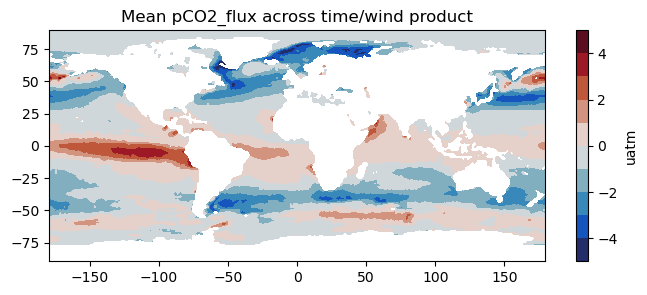

In [21]:
plot_data = flux_xr.flux.mean("time").mean("wind")  
levelspace = np.linspace(-5,5,11) 
fig,ax = plt.subplots(1,1,figsize=(8,3))
x0=ax.contourf(flux_xr.xlon,flux_xr.ylat,plot_data,levels=levelspace,cmap=cm.cm.balance)
plt.colorbar(x0,ax=ax).set_label('uatm');
ax.set_title("Mean "+'pCO2_flux'+ " across time/wind product");

## Enhancing / Summarizing Flux

In [22]:
# This code adjusts for ocean acea and summarizes glboally and annually

area = seaflux_filter.area #sarea.area_ocean
flux_tmp = flux_xr.flux * area * 12     # g/yr; flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
#flux_tmp = flux_tmp.where(mask['open_ocean']>=1).sum(['lat','lon'])  #this is old code; not required as land is already nan
flux_all_regions = flux_tmp.sum(['ylat','xlon'])  #sum over the region to get total flux in g/yr
flux_all_regions_corrected = flux_all_regions.where(flux_all_regions!=0)  #this is to correct for anomalies in data
#flux_all_regions_corrected = flux_all_regions_corrected/1e15 #(optionally) divide by 1e15 to get in Pg/yr

In [23]:
# Now compose an xarray to write out a file
# Note, we are only use 1 LDEO product so this code has been simplified from a previous version

annual_fluxes = flux_all_regions_corrected.groupby("time.year").mean("time")
flux_file_yearly = xr.Dataset({
                        'flux':(["time","wind"],flux_all_regions_corrected.data),  #calculated above
                        'annual_flux':(["year","wind"],annual_fluxes.data)},
                        coords={'time':(['time'],flux_all_regions_corrected.time.values),
                                'year':(['year'],range(int(start_yearmonth[0:4]), int(end_yearmonth[0:4])+1)),  #this is just a list of years
                                'wind':(['wind'],flux_all_regions_corrected.wind.values)  })

flux_file_yearly.flux.attrs['description'] = flux_variable+"-Residual integrated CO2 Flux (XGBoost ensemble mean)"
flux_file_yearly.flux.attrs['units'] = "g C /year (negative into ocean), no river flux adjustment done here"
flux_file_yearly.annual_flux.attrs['units'] = "g C /year (negative into ocean), no river flux adjustment done here"
flux_file_yearly.attrs['ocean_co2_source'] = str(reconstructed_file)
flux_file_yearly.attrs['seaflux_source'] = str(seaflux_file)
flux_file_yearly.attrs['coast_filling_source'] = str(coastal_filling_file)
flux_file_yearly.attrs['created'] = str(datetime.datetime.now())
#flux_xr.attrs['code'] = "/home/vbennington/pCO2_Residual/calc_fluxes.ipynb"

flux_file_yearly

<xarray.Dataset>
Dimensions:      (time: 492, wind: 3, year: 41)
Coordinates:
  * time         (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2022-12-15
  * year         (year) int64 1982 1983 1984 1985 1986 ... 2019 2020 2021 2022
  * wind         (wind) object 'CCMP2' 'ERA5' 'JRA55'
Data variables:
    flux         (time, wind) float64 nan -1.094e+15 ... -2.911e+15 -3.125e+15
    annual_flux  (year, wind) float64 nan -6.811e+14 ... -2.152e+15 -2.387e+15
Attributes:
    ocean_co2_source:      /data/artemis/workspace/ds4114/reconstructions/pCO...
    seaflux_source:        /data/artemis/workspace/ds4114/online_data/SeaFlux...
    coast_filling_source:  /data/artemis/workspace/ds4114/online_data/pCO2/pr...
    created:               2023-08-11 18:37:25.312160

In [26]:
#output flux to netcdf file
output_xarray_with_date(flux_file_yearly, output_folder+'', 'pCO2_LEAP_'+flux_variable+'-residual-flux-monthly-3winds-summary', filetype=output_file_type)

Saved pCO2_LEAP_fco2-residual-flux-monthly-3winds-summary_198201-202212.nc to /data/artemis/workspace/ds4114/reconstructions/


In [ ]:
river_carbon_adjustment = 0.49   #Pg/yr adjustment to be applied on all products 
plot_data = flux_file_yearly.flux.groupby("time.year").mean("time").mean('wind')/1e15 - river_carbon_adjustment

fig = plt.figure(figsize=(8,3))
plt.plot(flux_file_yearly.year,plot_data)
plt.grid(True)
plt.title('Annual CO2 Flux \n (avg 3 wind products; with riverine CO2 adj)'); 
plt.xlabel('Time'); plt.ylabel(flux_variable + ' Flux (Pg/yr)');